Based on:

- [Model Convolution: A Computational Approach to Digital Image Interpretation, 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2864900/)

In [1]:
%matplotlib inline

from pathlib import Path
import sys
sys.path.append("..")

import anamic

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv
import skimage

../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


In [2]:
# Define the structure of the MT
# as a 2D array where:
# - x corresponds to rows of dimers.
# - y corresponds to each protofilaments.

n_pf = 13
n_rows = 600

dimers = np.ones((n_pf, n_rows))
dimers = anamic.structure.generate_random_tapers(dimers, 0, 20)

#_ = anamic.viz.viz_dimers(dimers, start_row=0, grid=True)

# Calculate the x, y and z positions of each dimers.
positions = anamic.structure.get_dimer_positions(dimers)

# Apply a random rotation parallell to the surface (along the z axis)
rotation = np.deg2rad(np.random.randn() * 360)
Rz = anamic.transformations.rotation_matrix(rotation, [0, 0, 1])
positions[['x', 'y', 'z']] = np.dot(positions[['x', 'y', 'z']].values, Rz[:3, :3].T)

# Apply a certain labeling ratio
labeling_ratio = 0.1
positions['labeled'] = np.random.random(positions.shape[0]) < labeling_ratio

#anamic.viz.viz_dimer_positions(positions, size=0.4, color_feature_name='pf')

(4552.4504120765969, 4757.4504120765969)

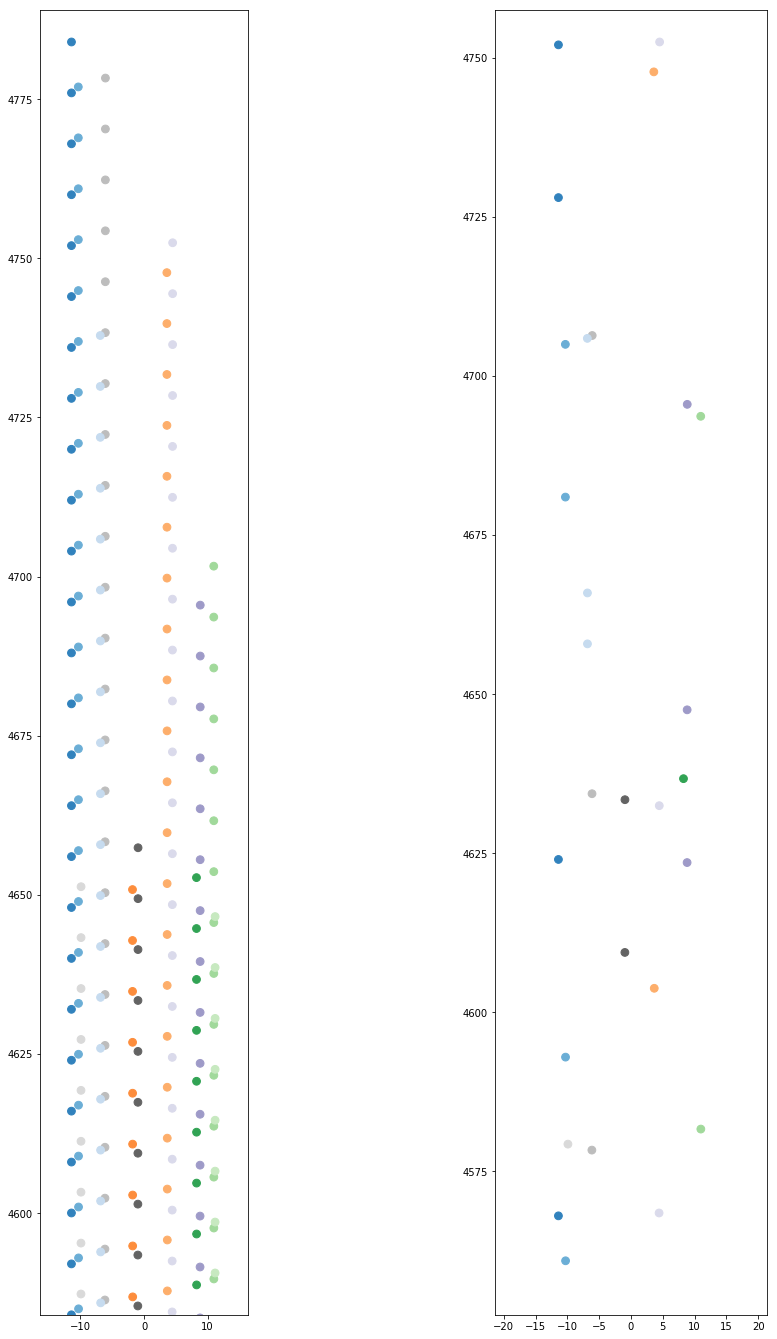

In [3]:
# Visualize projected dimer positions on a plan.

# We choose the XZ plan for projection so no need to project positions.

positions[['x_proj', 'y_proj']] = positions[['x', 'z']].copy()

color_feature_name = 'pf'
marker_size = 60
colormap = 'tab20c'

fig, axs = plt.subplots(ncols=2, figsize=(16, 24))

selected_dimers = positions[(positions['visible'] == True)]
axs[0].scatter(selected_dimers['x_proj'], selected_dimers['y_proj'], c=selected_dimers[color_feature_name],s=marker_size, cmap=colormap)
axs[0].set_aspect('equal')
axs[0].set_xlim(selected_dimers['x_proj'].min() - 5, selected_dimers['x_proj'].max() + 5)
axs[0].set_ylim(selected_dimers['y_proj'].max() - 200, selected_dimers['y_proj'].max() + 5)

selected_dimers = positions[(positions['visible'] == True) & (positions['labeled'] == True)]
axs[1].scatter(selected_dimers['x_proj'], selected_dimers['z'], c=selected_dimers[color_feature_name], s=marker_size, cmap=colormap)
axs[1].set_aspect('equal')
axs[1].set_xlim(selected_dimers['x_proj'].min() - 10, selected_dimers['x_proj'].max() + 10)
axs[1].set_ylim(selected_dimers['y_proj'].max() - 200, selected_dimers['y_proj'].max() + 5)

In [22]:
Rx

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.97213806,  0.23440902,  0.        ],
       [ 0.        , -0.23440902,  0.97213806,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [26]:
# Apply a random rotation of the projected microtubule
Rx = anamic.transformations.rotation_matrix(np.deg2rad(np.random.randn() * 360), [1, 0, 0])
Ry = anamic.transformations.rotation_matrix(np.deg2rad(np.random.randn() * 360), [0, 1, 0])
R = anamic.transformations.concatenate_matrices(Rx, Ry)

positions['x_proj_rotated'] = np.nan
positions['y_proj_rotated'] = np.nan
positions[['x_proj_rotated', 'y_proj_rotated']] = np.dot(positions[['x_proj', 'y_proj']].values, R[1:3, 1:3].T)

In [30]:
# Discretize dimers onto an high resolution image

microscope_pixel_size = 120  # nm/pixel
pixel_size_ratio = 20
fine_pixel_size = microscope_pixel_size / pixel_size_ratio
assert int(fine_pixel_size) == fine_pixel_size

x_offset = 600  # nm
y_offset = 400  # nm

x_max = int(np.round(positions['x_proj_rotated'].max() + 1))
x_min = int(np.round(positions['x_proj_rotated'].min() - 1))
y_max = int(np.round(positions['y_proj_rotated'].max() + 1))
y_min = int(np.round(positions['y_proj_rotated'].min() - 1))

x_bins = np.arange(x_min - x_offset, x_max + x_offset, fine_pixel_size)
y_bins = np.arange(y_min - y_offset, y_max + y_offset, fine_pixel_size)

# Select visible and labeled dimers
selected_dimers = positions[(positions['visible'] == True) & (positions['labeled'] == True)]

# Bin dimers positions to a fine grid (defined by fine_pixel_size)
im, _, _ = np.histogram2d(selected_dimers['x_proj_rotated'], selected_dimers['y_proj_rotated'], bins=[x_bins, y_bins])
if im.shape[1] > im.shape[0]:
    im = im.T

# We resize the image to be a multiple of `pixel_size_ratio` (usually the value is 10).
new_w = im.shape[0] + (pixel_size_ratio - im.shape[0] % pixel_size_ratio)
new_h = im.shape[1] + (pixel_size_ratio - im.shape[1] % pixel_size_ratio)

rows_to_add = np.zeros((new_w - im.shape[0], im.shape[1]))
im = np.vstack((im, rows_to_add))

columns_to_add = np.zeros((new_h - im.shape[1], im.shape[0])).T
im = np.hstack((im, columns_to_add))

assert im.shape == (new_w, new_h)

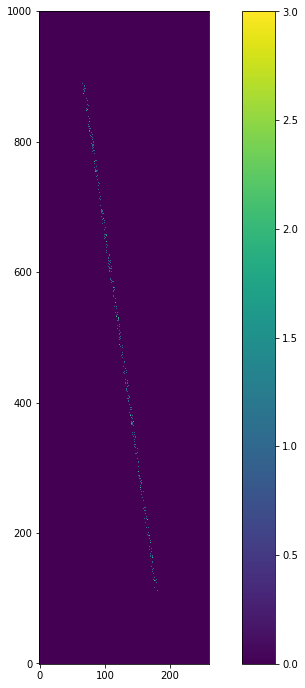

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))

mappable = ax.imshow(im, interpolation='none', origin=[0, 0])
ax.set_aspect('equal')
fig.colorbar(mappable, ax=ax, orientation='vertical')

In [32]:
# Rebin the image to its final resolution defined by `microscope_pixel_size`.

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).sum(-1).sum(1)

final_shape = np.array(im.shape) / pixel_size_ratio
assert int(final_shape[0]) == final_shape[0]
assert int(final_shape[1]) == final_shape[1]
final_shape = final_shape.astype('int')

im2 = rebin(im, final_shape)

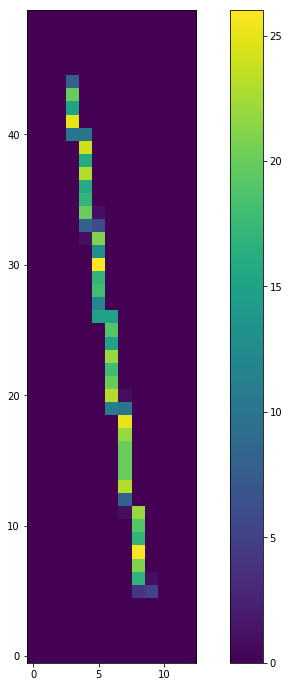

In [33]:
fig, ax = plt.subplots(figsize=(12, 12))

mappable = ax.imshow(im2, interpolation='none', origin=[0, 0])
ax.set_aspect('equal')
fig.colorbar(mappable, ax=ax, orientation='vertical')

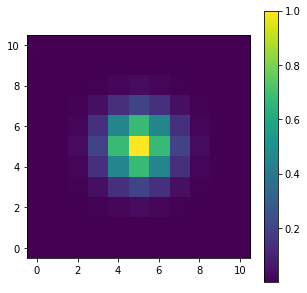

In [34]:
# Generate a microscope PSF

def generate_psf(kernel_size_pixel, sigma_pixel):
    from scipy import signal
    gaussian_kernel_1d = signal.gaussian(kernel_size_pixel, std=sigma_pixel)
    gaussian_kernel_1d = gaussian_kernel_1d.reshape(kernel_size_pixel, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    return gaussian_kernel_2d

psf_size = 135  # nm
sigma_pixel = psf_size / microscope_pixel_size

psf = generate_psf(int(sigma_pixel * 10), sigma_pixel)

fig, ax = plt.subplots(figsize=(5, 5))
mappable = ax.imshow(psf, interpolation='none', origin=[0, 0])
ax.set_aspect('equal')
fig.colorbar(mappable, ax=ax, orientation='vertical')

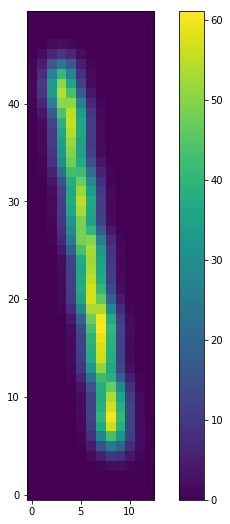

In [35]:
from scipy.ndimage import convolve

a = convolve(im2, psf, mode="constant")

fig, ax = plt.subplots(figsize=(9, 9))
mappable = ax.imshow(a, cmap="viridis", interpolation='none', origin=[0, 0])
ax.set_aspect('equal')
fig.colorbar(mappable, ax=ax, orientation='vertical')